<a href="https://colab.research.google.com/github/shajarian/Predictive-Analysis-for-Healthcare-Data/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predictive Analytics for Healthcare Data**

# ***Author: Shaghayegh (Shirley) Shajarian***


---


 **Objective:** To use a healthcare dataset to perform predictive analysis by processing the data with PySpark, handling missing values, normalizing data, and reducing dimensionality using PCA.


**Hospital Compare Data:** Contains information about the quality of care at over 4,000 Medicare-certified hospitals across the country. This dataset can be used to predict hospital performance metrics and outcomes. It covers a variety of metrics such as mortality, safety of care, readmission, patient experience, and timely and effective care. The data is structured to support quality comparisons, making it a good candidate for the analysis needs.

The Overall Hospital Quality Star Rating dataset is frequently updated and refined based on public input and expert recommendations, ensuring reliability and relevance. It summarizes data from existing measures into an easy-to-understand format, which can be beneficial for machine learning models where feature selection and dimension reduction via PCA are necessary. Additionally, handling missing values will be an integral part of preprocessing this dataset, providing a practical challenge in data cleaning and preparation.

https://data.cms.gov/provider-data/topics/hospitals


The Hospital Compare dataset contains multiple CSV files, each catering to different aspects of hospital performance. For the sake of this research, which is a machine learning project focused on predictive analytics and PCA, Hospital General Information, which Contains basic details about each hospital, such as name, location, and hospital type, is the appropriate dataset.

# **Step 1: Mount the dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/My Drive/Semester 3/Big Data/Project"

advertising.zip  hospitals_current_data.zip  living.zip


In [ ]:
!unzip -o "/content/drive/My Drive/Semester 3/Big Data/Project/hospitals_current_data.zip" -d "/content/dataset"

Archive:  /content/drive/My Drive/Semester 3/Big Data/Project/hospitals_current_data.zip
  inflating: /content/dataset/Medicare_Hospital_Spending_Per_Patient-National.csv  
  inflating: /content/dataset/ASCQR_OAS_CAHPS_BY_ASC.csv  
  inflating: /content/dataset/Unplanned_Hospital_Visits-State.csv  
  inflating: /content/dataset/Measure_Dates.csv  
  inflating: /content/dataset/ASC_Facility.csv  
  inflating: /content/dataset/FY2021_Net_Change_in_Base_Op_DRG_Payment_Amt.csv  
  inflating: /content/dataset/HOSPITAL_QUARTERLY_MSPB_6_DECIMALS.csv  
  inflating: /content/dataset/Unplanned_Hospital_Visits-Hospital.csv  
  inflating: /content/dataset/OQR_OAS_CAHPS_STATE.csv  
  inflating: /content/dataset/VA_IPF.csv  
  inflating: /content/dataset/Healthcare_Associated_Infections-Hospital.csv  
  inflating: /content/dataset/HCAHPS-State.csv  
  inflating: /content/dataset/Payment-State.csv  
  inflating: /content/dataset/HCAHPS-National.csv  
  inflating: /content/dataset/PCH_HCAHPS_NATIONAL.

# **Step 2: Setting Up PySpark in Google Colab**
First, I'll need to install PySpark and initialize a Spark session in Google Colab. *italicized text*

In [ ]:
# Install PySpark
!pip install pyspark

# Import SparkSession
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder.master("local[*]").appName("Hospital Compare Analysis").getOrCreate()

# **Step 3: Loading the Data**
Once PySpark is set up, I can load the CSV files into PySpark DataFrames. For the sake of this project we consider the "Hospital General Information" file.

In [ ]:
# Load the dataset
df = spark.read.csv('/content/dataset/Hospital_General_Information.csv', header=True, inferSchema=True)

# Show the first few rows of the DataFrame
df.show(10)

# Print the schema to understand the data types
df.printSchema()

+-----------+--------------------+--------------------+----------+-----+--------+-------------+----------------+--------------------+--------------------+------------------+-----------------------------------------------------+------------------------------------------------+-----------------------+--------------------------------+------------------------+-------------------------------+-----------------------------+-----------------------------------+----------------------------+-------------------+--------------------------+---------------------------------+-------------------------------+-------------------------------------+------------------------------+---------------------+-------------------------+--------------------------------+------------------------------+------------------------------------+-----------------------------+--------------------+--------------------------+---------------------------------+---------------------+----------------------+---------------------------

# **Step 4: Data Exploration and Cleaning**
The dataset has a mixture of numeric and categorical fields, some of which contain missing values and "Not Available" entries. Here’s how we can proceed with the data exploration and cleaning:

**1. Remove unnecessary columns**

Decide which columns are relevant for the analysis and drop unnecessary columns.

In [ ]:
# Dropping columns that are not needed
df = df.drop('Telephone Number', 'County/Parish', 'Address', 'ZIP Code', 'Emergency Services','Meets criteria for promoting interoperability of EHRs','Meets criteria for birthing friendly designation','Hospital overall rating footnote', 'Safety Group Footnote', 'READM Group Footnote', 'Pt Exp Group Footnote', 'E Group Footnote', 'MORT Group Footnote', 'TE Group Footnote')

df.show(10)

+-----------+--------------------+----------+-----+--------------------+--------------------+-----------------------+------------------------+-------------------------------+-----------------------------+-----------------------------------+----------------------------+--------------------------+---------------------------------+-------------------------------+-------------------------------------+------------------------------+-------------------------+--------------------------------+------------------------------+------------------------------------+-----------------------------+--------------------------+---------------------------------+----------------------+-----------------------------+
|Facility ID|       Facility Name| City/Town|State|       Hospital Type|  Hospital Ownership|Hospital overall rating|MORT Group Measure Count|Count of Facility MORT Measures|Count of MORT Measures Better|Count of MORT Measures No Different|Count of MORT Measures Worse|Safety Group Measure Count|C

**2. Explore Missing Values and "Not Available" Entries**
The dataset have some fields with "Not Available" as a placeholder for missing data. We'll need to convert these to actual null values and assess the proportion of missing data.

In [ ]:
from pyspark.sql.functions import col, when, count

# Replace 'Not Available' with None (null in PySpark)
df = df.replace('Not Available', None)

df.show(10)

+-----------+--------------------+----------+-----+--------------------+--------------------+-----------------------+------------------------+-------------------------------+-----------------------------+-----------------------------------+----------------------------+--------------------------+---------------------------------+-------------------------------+-------------------------------------+------------------------------+-------------------------+--------------------------------+------------------------------+------------------------------------+-----------------------------+--------------------------+---------------------------------+----------------------+-----------------------------+
|Facility ID|       Facility Name| City/Town|State|       Hospital Type|  Hospital Ownership|Hospital overall rating|MORT Group Measure Count|Count of Facility MORT Measures|Count of MORT Measures Better|Count of MORT Measures No Different|Count of MORT Measures Worse|Safety Group Measure Count|C

In [ ]:
# Count the number of nulls in each column
null_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
null_counts.show()

+-----------+-------------+---------+-----+-------------+------------------+-----------------------+------------------------+-------------------------------+-----------------------------+-----------------------------------+----------------------------+--------------------------+---------------------------------+-------------------------------+-------------------------------------+------------------------------+-------------------------+--------------------------------+------------------------------+------------------------------------+-----------------------------+--------------------------+---------------------------------+----------------------+-----------------------------+
|Facility ID|Facility Name|City/Town|State|Hospital Type|Hospital Ownership|Hospital overall rating|MORT Group Measure Count|Count of Facility MORT Measures|Count of MORT Measures Better|Count of MORT Measures No Different|Count of MORT Measures Worse|Safety Group Measure Count|Count of Facility Safety Measures|C

**3. Handling Missing Values with Imputation**
Depending on the proportion of missing values and the importance of the column, we can choose to fill them with a placeholder value, the median/mode, or drop the column if too many values are missing.

To determine which columns in the dataset have excessive missing values, we can calculate the proportion of null values for each column and decide on a threshold for dropping columns based on those proportions. For example, we might decide that any column with more than 50% missing values should be considered for removal.

Here's how we can calculate the proportion of missing values for each column in the PySpark DataFrame:

In [ ]:
from pyspark.sql.functions import col, lit, count

# Total number of rows in the DataFrame
total_count = df.count()

# Calculating the proportion of missing values for each column
null_proportions = df.select([(count(when(col(c).isNull(), c)) / lit(total_count)).alias(c) for c in df.columns])

# Showing the proportion of nulls for each column
null_proportions.show()

+-----------+-------------+---------+-----+-------------+------------------+-----------------------+------------------------+-------------------------------+-----------------------------+-----------------------------------+----------------------------+--------------------------+---------------------------------+-------------------------------+-------------------------------------+------------------------------+-------------------------+--------------------------------+------------------------------+------------------------------------+-----------------------------+--------------------------+---------------------------------+----------------------+-----------------------------+
|Facility ID|Facility Name|City/Town|State|Hospital Type|Hospital Ownership|Hospital overall rating|MORT Group Measure Count|Count of Facility MORT Measures|Count of MORT Measures Better|Count of MORT Measures No Different|Count of MORT Measures Worse|Safety Group Measure Count|Count of Facility Safety Measures|C

We want to automatically drop columns based on a certain threshold of missing values.

In [ ]:
# Threshold for dropping columns
threshold = 0.5  # 50%

# List columns to drop based on threshold
columns_to_drop = [c for c in df.columns if (df.select((count(when(col(c).isNull(), c)) / lit(total_count)).alias(c)).first()[c] > threshold)]

# Drop these columns from the DataFrame
df = df.drop(*columns_to_drop)

In [ ]:
df.show(10)

+-----------+--------------------+----------+-----+--------------------+--------------------+-----------------------+------------------------+-------------------------------+-----------------------------+-----------------------------------+----------------------------+--------------------------+---------------------------------+-------------------------------+-------------------------------------+------------------------------+-------------------------+--------------------------------+------------------------------+------------------------------------+-----------------------------+--------------------------+---------------------------------+----------------------+-----------------------------+
|Facility ID|       Facility Name| City/Town|State|       Hospital Type|  Hospital Ownership|Hospital overall rating|MORT Group Measure Count|Count of Facility MORT Measures|Count of MORT Measures Better|Count of MORT Measures No Different|Count of MORT Measures Worse|Safety Group Measure Count|C

In PySpark, we can identify which columns in the DataFrame are categorical and which are numerical by examining the data types of each column. Categorical variables are typically represented by string types or sometimes integer types (if they are encoded), whereas numerical variables are represented by numeric types like integers or doubles.

Here’s how we can programmatically check the data types of each column and classify them as categorical or numerical:

In [ ]:
from pyspark.sql.types import StringType, IntegerType, DoubleType, FloatType, NumericType

# Get the DataFrame schema, which contains data types for each column
schema = df.schema

# Initialize lists to store the names of categorical and numerical columns
categorical_columns = []
numerical_columns = []

# Iterate over the schema to classify columns
for field in schema.fields:
    if isinstance(field.dataType, StringType):
        categorical_columns.append(field.name)
    elif isinstance(field.dataType, (IntegerType, DoubleType, FloatType, NumericType)):
        numerical_columns.append(field.name)

# Print the lists of categorical and numerical columns
print("Categorical columns:", categorical_columns)
print("Numerical columns:", numerical_columns)

Categorical columns: ['Facility Name', 'City/Town', 'State', 'Hospital Type', 'Hospital Ownership', 'Hospital overall rating', 'MORT Group Measure Count', 'Count of Facility MORT Measures', 'Count of MORT Measures Better', 'Count of MORT Measures No Different', 'Count of MORT Measures Worse', 'Safety Group Measure Count', 'Count of Facility Safety Measures', 'Count of Safety Measures Better', 'Count of Safety Measures No Different', 'Count of Safety Measures Worse', 'READM Group Measure Count', 'Count of Facility READM Measures', 'Count of READM Measures Better', 'Count of READM Measures No Different', 'Count of READM Measures Worse', 'Pt Exp Group Measure Count', 'Count of Facility Pt Exp Measures', 'TE Group Measure Count', 'Count of Facility TE Measures']
Numerical columns: ['Facility ID']


As we can see, the numerical columns such as 'hospital overall rating' are categorized as categorical. This is because we put 'Null' instead of 'Not Available' data. So to handle these missing value For numeric columns, I can impute missing values with the median (as median is less affected by outliers than the mean). So this is the process for this imputation:

**Identifying Numeric Columns:** Initially, ensure all the relevant columns are in the correct numeric format.

**Calculating Median:** approxQuantile method is used to find the median. The second parameter [0.5] represents the median (50th percentile), and 0.0 is the relative error – a zero value means exact computation.

**Replacing Nulls:** The na.fill() function replaces null values with the median calculated for each column.

This process ensures that the numerical data is treated appropriately, leading to more accurate analyses and model predictions.

In [ ]:
from pyspark.sql.types import DoubleType

# Casting columns that should be numeric but are strings
numeric_cols = [ 'Hospital overall rating', 'MORT Group Measure Count', 'Count of Facility MORT Measures', 'Count of MORT Measures Better', 'Count of MORT Measures No Different', 'Count of MORT Measures Worse', 'Safety Group Measure Count', 'Count of Facility Safety Measures', 'Count of Safety Measures Better', 'Count of Safety Measures No Different', 'Count of Safety Measures Worse', 'READM Group Measure Count', 'Count of Facility READM Measures', 'Count of READM Measures Better', 'Count of READM Measures No Different', 'Count of READM Measures Worse', 'Pt Exp Group Measure Count', 'Count of Facility Pt Exp Measures', 'TE Group Measure Count', 'Count of Facility TE Measures']
for col_name in numeric_cols:
    df = df.withColumn(col_name, df[col_name].cast(DoubleType()))

In [ ]:
from pyspark.sql.functions import col

for col_name in numeric_cols:
    # Calculate median
    median_value = df.stat.approxQuantile(col_name, [0.5], 0.0)[0]

    # Replace nulls with the median
    df = df.na.fill({col_name: median_value})

In [ ]:
df.show(10)

+-----------+--------------------+----------+-----+--------------------+--------------------+-----------------------+------------------------+-------------------------------+-----------------------------+-----------------------------------+----------------------------+--------------------------+---------------------------------+-------------------------------+-------------------------------------+------------------------------+-------------------------+--------------------------------+------------------------------+------------------------------------+-----------------------------+--------------------------+---------------------------------+----------------------+-----------------------------+
|Facility ID|       Facility Name| City/Town|State|       Hospital Type|  Hospital Ownership|Hospital overall rating|MORT Group Measure Count|Count of Facility MORT Measures|Count of MORT Measures Better|Count of MORT Measures No Different|Count of MORT Measures Worse|Safety Group Measure Count|C

In [ ]:
df.select(numeric_cols).show()

+-----------------------+------------------------+-------------------------------+-----------------------------+-----------------------------------+----------------------------+--------------------------+---------------------------------+-------------------------------+-------------------------------------+------------------------------+-------------------------+--------------------------------+------------------------------+------------------------------------+-----------------------------+--------------------------+---------------------------------+----------------------+-----------------------------+
|Hospital overall rating|MORT Group Measure Count|Count of Facility MORT Measures|Count of MORT Measures Better|Count of MORT Measures No Different|Count of MORT Measures Worse|Safety Group Measure Count|Count of Facility Safety Measures|Count of Safety Measures Better|Count of Safety Measures No Different|Count of Safety Measures Worse|READM Group Measure Count|Count of Facility READM 

Hence, as the result shows, we successfully imputated all missing values in our dataset.

# **Step 5: PCA**
After cleaning, the next step is preparing the data for PCA and any subsequent machine learning analysis. We can do following steps in this section:

**Step 1: Prepare the Data**

First, we need to assemble all numerical features into a single vector column using VectorAssembler. This is required because PCA in PySpark operates on vector columns.

In [ ]:
from pyspark.ml.feature import VectorAssembler

# List of numerical features for PCA
features_list = [col for col in df.columns if isinstance(df.schema[col].dataType, (DoubleType, FloatType, IntegerType))]

# Assemble features into a single vector column called 'features'
assembler = VectorAssembler(inputCols=features_list, outputCol="features")
df_vector = assembler.transform(df)

**Step 2: Normalize the Data**

It's important to normalize the data before applying PCA since PCA is sensitive to variances of the initial variables.

In [ ]:
from pyspark.ml.feature import StandardScaler

# Normalize each feature to have unit standard deviation and/or zero mean
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
scaler_model = scaler.fit(df_vector)
df_scaled = scaler_model.transform(df_vector)

**Step 3: Apply PCA**

Now, apply PCA to the scaled features. You can choose the number of principal components you want to keep.

In [ ]:
from pyspark.ml.feature import PCA

# Number of principal components to keep
k = 3

# Apply PCA
pca = PCA(k=k, inputCol="scaledFeatures", outputCol="pcaFeatures")
model = pca.fit(df_scaled)
df_pca = model.transform(df_scaled)

# Show the results
df_pca.select("pcaFeatures").show(truncate=False)

+---------------------------------------------------------------+
|pcaFeatures                                                    |
+---------------------------------------------------------------+
|[4.122808247565187,-0.6151229931121314,1.3103036016100251]     |
|[2.992389070562646,-3.0193351835728794,-1.8688691907088215]    |
|[3.4728131162932434,-3.8807582630667947,-0.02395267560607048]  |
|[-1.8466500560040997,-1.066359903246226,0.2924093174097487]    |
|[-3.0012002684917447,-0.5638312732440159,1.1941295694612708]   |
|[2.701402374159165,-0.7329087039797045,-0.15995867744818465]   |
|[-0.06358962444327221,0.14117957325526703,-0.5573147429988111] |
|[3.065721499086916,0.46569072253842836,0.5218037270958167]     |
|[-3.0343482468960863,-0.37300691403585956,0.5969642640180348]  |
|[1.8388486310003849,-3.517063275157516,-1.0489375383000488]    |
|[-1.9748876454663868,0.09125804460222592,-0.16209127803052828] |
|[-3.2442842285028637,-0.40728463760297035,0.8188950526881629]  |
|[3.963451

**Step 4: Explained Variance**

Let's look at the explained variance by each principal component to understand how much information is retained.

In [ ]:
# Explained variance
explained_variance = model.explainedVariance
print("Explained Variance: ", explained_variance)

Explained Variance:  [0.35755443171761014,0.10850951501375784,0.08668899226793664]


We can now use the PCA results (df_pca) for further analysis or as inputs to other machine learning models. Overall, PCA often helps improve the performance of models by reducing the number of dimensions and removing multicollinearity.

# **Step 6: Move Forward to Machine Learning**
Given that you've preprocessed your dataset and applied PCA, moving forward to a machine learning task focused on comparing hospitals would be an excellent way to utilize your data. One interesting approach could be to predict hospital ratings based on various performance metrics or to classify hospitals into categories based on their quality of care.

**Step 1: Define the Machine Learning Task**
Since you're interested in comparing hospitals, a predictive modeling task, such as predicting the "Hospital overall rating" based on other features, could be valuable. This could help identify key factors that influence hospital ratings and guide improvements in healthcare services.

*Predictive Model:* Hospital Rating Prediction


*   Objective: Predict the 'Hospital overall rating' using other available metrics and features.
*   Model Type: Regression (since the rating is a numerical value).




In [ ]:
df_pca.show(5)

+-----------+--------------------+---------+-----+--------------------+--------------------+-----------------------+------------------------+-------------------------------+-----------------------------+-----------------------------------+----------------------------+--------------------------+---------------------------------+-------------------------------+-------------------------------------+------------------------------+-------------------------+--------------------------------+------------------------------+------------------------------------+-----------------------------+--------------------------+---------------------------------+----------------------+-----------------------------+--------------------+--------------------+--------------------+
|Facility ID|       Facility Name|City/Town|State|       Hospital Type|  Hospital Ownership|Hospital overall rating|MORT Group Measure Count|Count of Facility MORT Measures|Count of MORT Measures Better|Count of MORT Measures No Differ

**Step 2: Prepare Data for Modeling**
You need to prepare your dataset by selecting the relevant features and the target variable.

In [ ]:
# Select features and target for the model
from pyspark.ml.feature import VectorAssembler

# Use PCA features for prediction and specify a different output column name
assembler = VectorAssembler(inputCols=["pcaFeatures"], outputCol="assembledFeatures")
data_model = assembler.transform(df_pca)

# Selecting the target variable and features
final_data = data_model.select(col("assembledFeatures").alias("features"), col("Hospital overall rating").alias("label"))

**Step 3: Split the Data**
Divide your data into training and testing sets to evaluate the performance of your model.

In [ ]:
# Split the data into training and testing sets
train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=123)

**Step 4: Choose a Model and Train It**
For a regression task, you can start with a simple model like Linear Regression

In [ ]:
from pyspark.ml.regression import LinearRegression

# Initialize and fit the Linear Regression model
lr = LinearRegression(featuresCol='features', labelCol='label')

# Fit the model on training data
lr_model = lr.fit(train_data)

# Print the coefficients and intercept
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [0.012504685937647086,0.6029750591026507,0.09862662849081295]
Intercept: 3.111309065560189


**Interpreting Coefficients:**
The coefficients we obtained from thr linear regression model tell us how much the predicted hospital rating is expected to change with a one-unit change in each principal component, assuming other components remain constant.

First Component (0.0125): A smaller positive impact on the rating. This might represent underlying features less directly associated with overall quality but still contributing positively.
Second Component (0.603): A significant positive impact, suggesting that this component captures aspects strongly associated with higher hospital ratings.
Third Component (0.099): Also a positive contribution but less than the second, indicating its moderate importance in the model.

**Interpreting the Intercept:**
Intercept (3.1113): This is the average expected rating when all principal components are at their mean value (post-scaling). Given the PCA and scaling, this can be seen as a baseline rating in the transformed feature space.

**Step 5: Evaluate the Model**
Use the test data to evaluate the model's performance. Common metrics for regression are RMSE (Root Mean Squared Error) and R2.

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# Make predictions on test data
predictions = lr_model.transform(test_data)

# Initialize the evaluator
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

# Calculate RMSE
lr_rmse = evaluator.evaluate(predictions)
print(f"RMSE on test data: {lr_rmse}")

# Calculate R-squared
lr_r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})
print(f"R2 on test data: {lr_r2}")

RMSE on test data: 0.4576977395595193
R2 on test data: 0.7147283836799107


With an R2 of about 0.715, your model explains approximately 71.5% of the variability in hospital ratings, which is quite good for a first attempt in predictive modeling in this context. The RMSE of 0.458 indicates the average error in the predicted ratings, which seems reasonable depending on the rating scale.

Now we can improve the model with more advanced machine learning techniques. We'll explore three different models: Decision Tree, Random Forest, and Gradient Boosting Machines (GBM), using PySpark's MLlib.

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

**Decision Tree Regressor**
Let's start with a simple Decision Tree model.

In [ ]:
# Initialize the Decision Tree Regressor
dt = DecisionTreeRegressor(featuresCol='features', labelCol='label')

# Fit the model
dt_model = dt.fit(train_data)

# Make predictions
dt_predictions = dt_model.transform(test_data)

# Evaluate the model
dt_evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
dt_rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data for Decision Tree = %g" % dt_rmse)

# Calculate R-squared
dt_r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})
print(f"R2 on test data: {dt_r2}")

Root Mean Squared Error (RMSE) on test data for Decision Tree = 0.411512
R2 on test data: 0.7147283836799107


**Random Forest Regressor**
Now, let's use a Random Forest model, which generally performs better due to its ensemble method, reducing overfitting.

In [ ]:
# Initialize the Random Forest Regressor
rf = RandomForestRegressor(featuresCol='features', labelCol='label', numTrees=10)

# Fit the model
rf_model = rf.fit(train_data)

# Make predictions
rf_predictions = rf_model.transform(test_data)

# Evaluate the model
rf_rmse = dt_evaluator.evaluate(rf_predictions)
print("Root Mean Squared Error (RMSE) on test data for Random Forest = %g" % rf_rmse)

# Calculate R-squared
rf_r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})
print(f"R2 on test data: {rf_r2}")

Root Mean Squared Error (RMSE) on test data for Random Forest = 0.511669
R2 on test data: 0.7147283836799107


**Gradient Boosting Machines (GBM)**
Finally, let's apply a Gradient Boosting Machine model for potentially better performance

In [ ]:
# Initialize the GBT Regressor
gbt = GBTRegressor(featuresCol='features', labelCol='label', maxIter=10)

# Fit the model
gbt_model = gbt.fit(train_data)

# Make predictions
gbt_predictions = gbt_model.transform(test_data)

# Evaluate the model
gbt_rmse = dt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data for GBT = %g" % gbt_rmse)

# Calculate R-squared
gbt_r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})
print(f"R2 on test data: {gbt_r2}")

Root Mean Squared Error (RMSE) on test data for GBT = 0.391796
R2 on test data: 0.7147283836799107


**Model Tuning with Cross-Validation**
To further enhance the model, consider using CrossValidator along with ParamGridBuilder for hyperparameter tuning. This is particularly useful for Random Forest and GBT models.

In [ ]:
# Setup parameter grid for model tuning
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 30]) \
    .addGrid(gbt.maxIter, [10, 20]) \
    .build()

# Setup CrossValidator
crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=dt_evaluator,
                          numFolds=3)  # Use 3+ folds

# Run cross-validation, and choose the best set of parameters.
cv_model = crossval.fit(train_data)

# Fetch best model
best_model = cv_model.bestModel

# Evaluate best model
best_predictions = best_model.transform(test_data)
best_rmse = dt_evaluator.evaluate(best_predictions)
print("Best Model RMSE: %g" % best_rmse)

Best Model RMSE: 0.391427


# **Step 7: Visualization**

Visualizing the results of your machine learning models and their evaluation metrics can provide clear insights and make your findings more accessible, especially when presenting to stakeholders or integrating into reports. Here’s how you can visualize key aspects of your models using Python libraries like matplotlib and seaborn, which work well in Jupyter Notebooks or similar environments.

**Install Visualization Libraries**

In [ ]:
!pip install matplotlib seaborn

**Import Libraries**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

This plot helps in understanding which features have the most significant impact on the target variable, with the magnitude and direction (positive/negative) of the coefficients indicating the nature of the impact.

**Comparing Model Performances (RMSE and R²)**
Create a bar plot to compare the RMSE and R² of each model.

<ipython-input-65-5d06d219e704>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='RMSE', data=performance_df, palette='pastel')


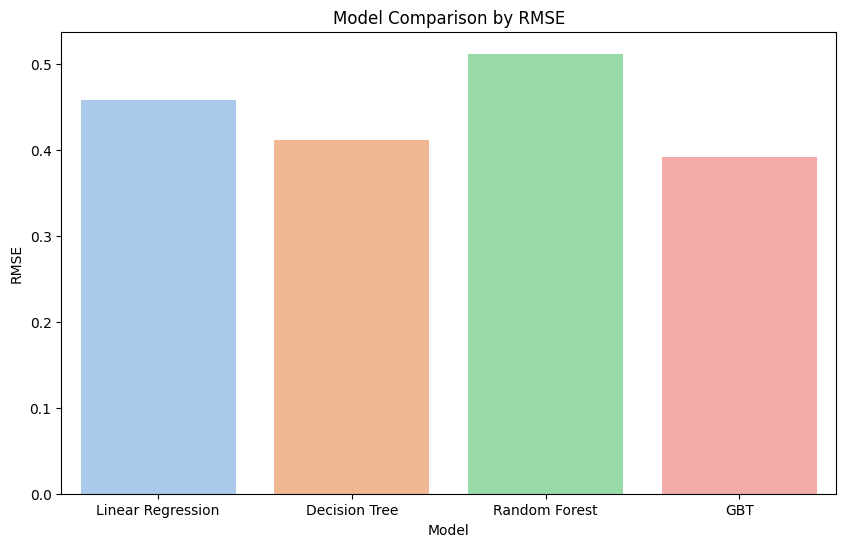

<ipython-input-65-5d06d219e704>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='R2', data=performance_df, palette='pastel')


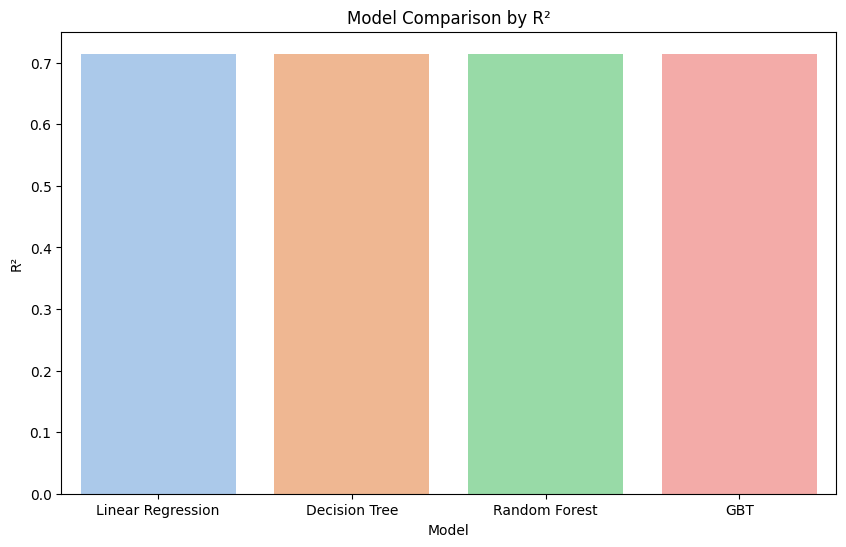

In [ ]:
# Model names and their respective RMSE and R² values
models = ['Linear Regression', 'Decision Tree', 'Random Forest', 'GBT']
rmse_values = [lr_rmse, dt_rmse, rf_rmse, gbt_rmse]  # Replace these with actual values
r2_values = [lr_r2, dt_r2, rf_r2, gbt_r2]  # Replace these with actual values

# Create a DataFrame for easier plotting
performance_df = pd.DataFrame({
    'Model': models,
    'RMSE': rmse_values,
    'R2': r2_values
})

# Plotting RMSE
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='RMSE', data=performance_df, palette='pastel')
plt.title('Model Comparison by RMSE')
plt.ylabel('RMSE')
plt.show()

# Plotting R2
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='R2', data=performance_df, palette='pastel')
plt.title('Model Comparison by R²')
plt.ylabel('R²')
plt.show()

**Visualizing Feature Importances or Coefficients**
To visualize feature importances for all four models (Linear Regression, Decision Tree, Random Forest, GBT) where applicable, you'll want to consider that not all models inherently provide feature importance metrics. Linear Regression, for instance, provides coefficients rather than importances, which serve a similar purpose but aren't directly comparable to the metrics provided by tree-based models.

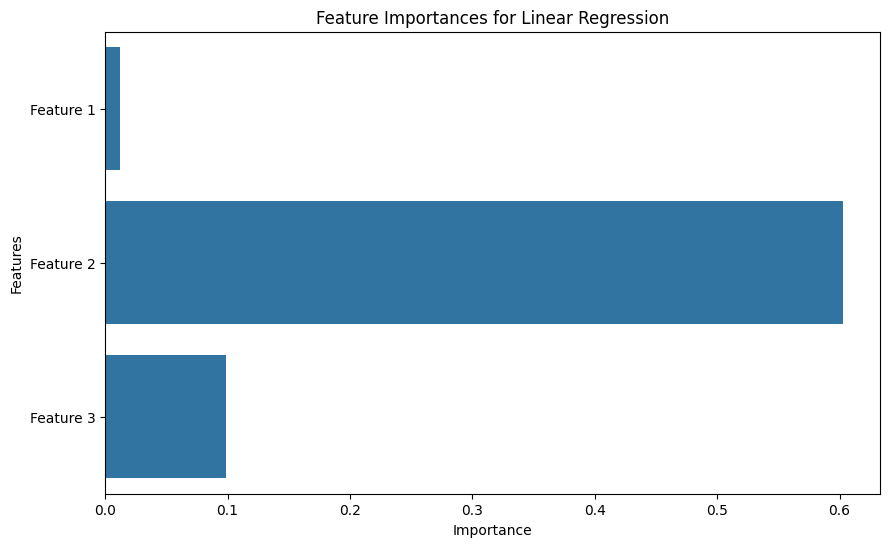

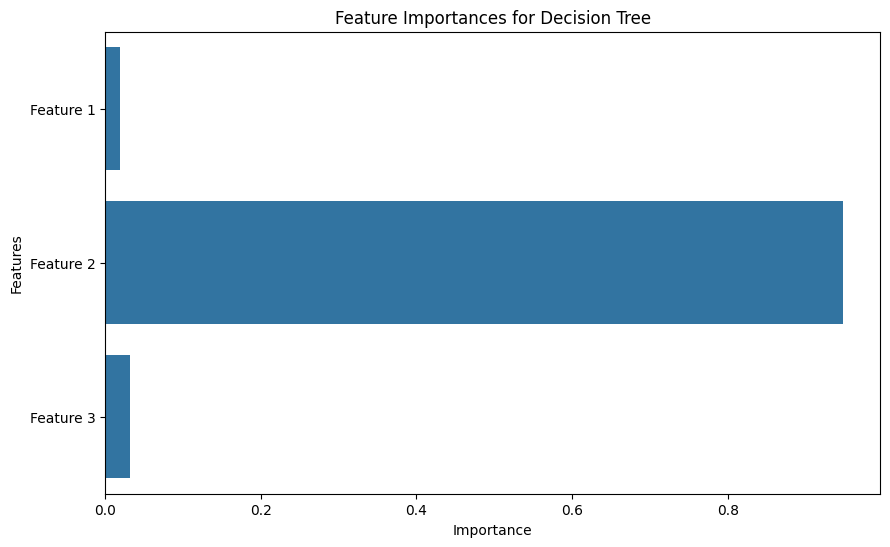

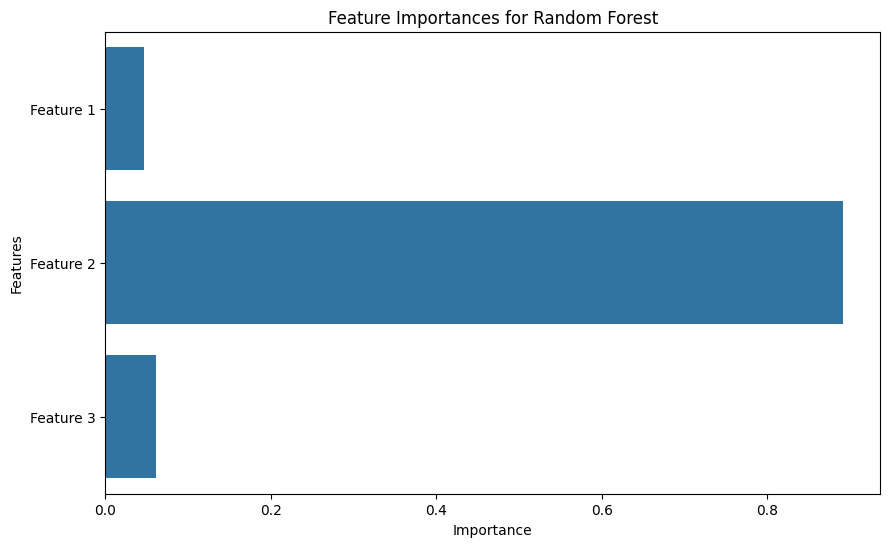

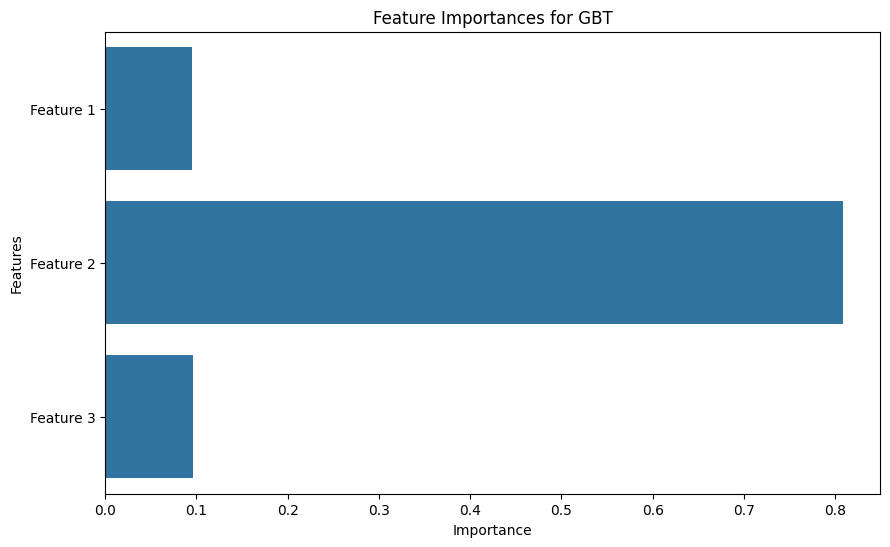

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'lr_model' is your trained Linear Regression model
lr_coefficients = lr_model.coefficients.toArray()  # Convert to array if necessary
features = ['Feature 1', 'Feature 2', 'Feature 3']  # Update with your actual feature names

# Feature Importances from Decision Tree
dt_importances = dt_model.featureImportances.toArray()

# Feature Importances from Random Forest
rf_importances = rf_model.featureImportances.toArray()

# Feature Importances from GBT
gbt_importances = gbt_model.featureImportances.toArray()



import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot feature importances or coefficients
def plot_feature_impact(importances, model_name, feature_names):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances, y=feature_names, orient='h')
    plt.title(f'Feature Importances for {model_name}')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.show()

# Plotting for each model
plot_feature_impact(lr_coefficients, 'Linear Regression', features)
plot_feature_impact(dt_importances, 'Decision Tree', features)
plot_feature_impact(rf_importances, 'Random Forest', features)
plot_feature_impact(gbt_importances, 'GBT', features)

So this is the summarization of these figures:


1.   *Linear Regression:* The values are coefficients, indicating how much the predicted value changes for a one unit increase in each feature. Positive values indicate a positive impact on the response variable, and negative values indicate a negative impact.
2.   *Tree-Based Models:* The values represent the importance of each feature in constructing the model, with higher values indicating a greater impact on the decision process.

**Visualizing Residuals for Each Model**

To visualize residuals for all four models—Linear Regression, Decision Tree, Random Forest, and Gradient Boosting Trees (GBT)—we need to understand that residuals plots are typically more informative for regression-type models. They help diagnose issues in the model such as non-linearity, heteroscedasticity, and outliers.

*Step 1: Generate Predictions*

For each model, you'll need to run predictions on your test dataset:

In [ ]:
# Assuming test_data is your testing dataset already prepared with 'features' and 'label'
lr_predictions = lr_model.transform(test_data)
dt_predictions = dt_model.transform(test_data)
rf_predictions = rf_model.transform(test_data)
gbt_predictions = gbt_model.transform(test_data)

*Step 2: Calculate Residuals*

For each set of predictions, calculate the residuals, which are the differences between the observed values and the predictions:

In [ ]:
# Adding residuals to each DataFrame
lr_predictions = lr_predictions.withColumn('Residuals', lr_predictions['label'] - lr_predictions['prediction'])
dt_predictions = dt_predictions.withColumn('Residuals', dt_predictions['label'] - dt_predictions['prediction'])
rf_predictions = rf_predictions.withColumn('Residuals', rf_predictions['label'] - rf_predictions['prediction'])
gbt_predictions = gbt_predictions.withColumn('Residuals', gbt_predictions['label'] - gbt_predictions['prediction'])

*Step 3: Convert to Pandas for Plotting*

To facilitate plotting, convert Spark DataFrame to Pandas DataFrame:

In [ ]:
lr_predictions_pd = lr_predictions.select('prediction', 'Residuals').toPandas()
dt_predictions_pd = dt_predictions.select('prediction', 'Residuals').toPandas()
rf_predictions_pd = rf_predictions.select('prediction', 'Residuals').toPandas()
gbt_predictions_pd = gbt_predictions.select('prediction', 'Residuals').toPandas()

*Step 4: Visualizing Residuals*

Using matplotlib and seaborn for creating residuals plots:

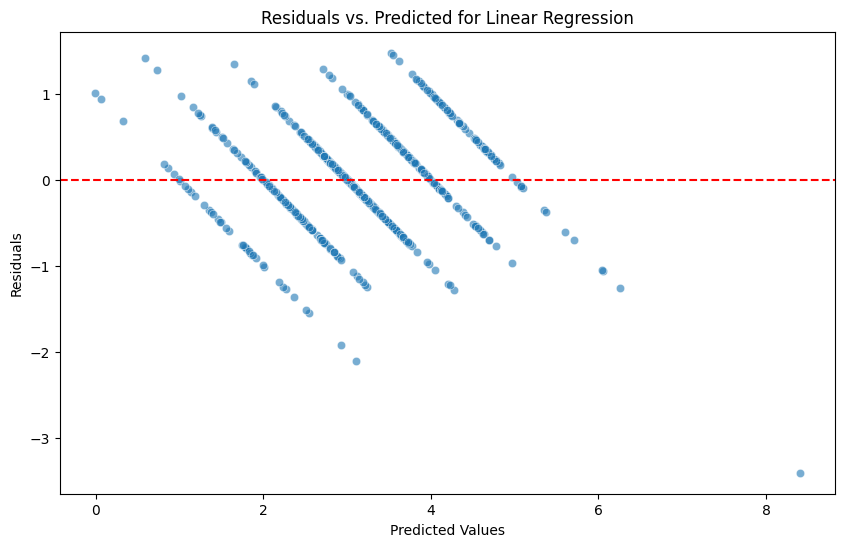

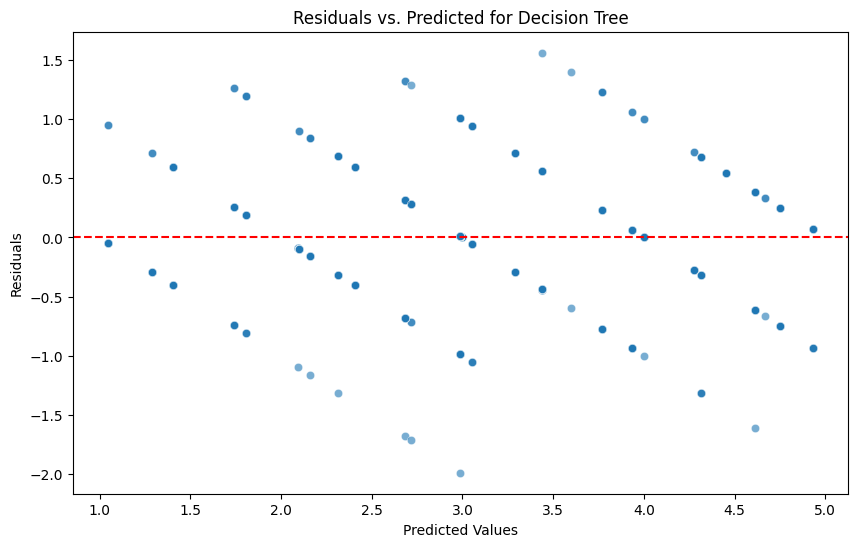

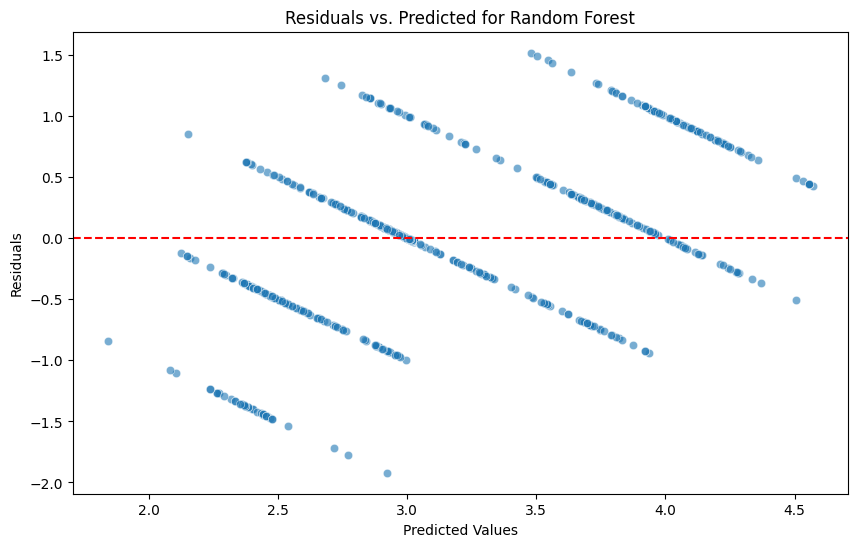

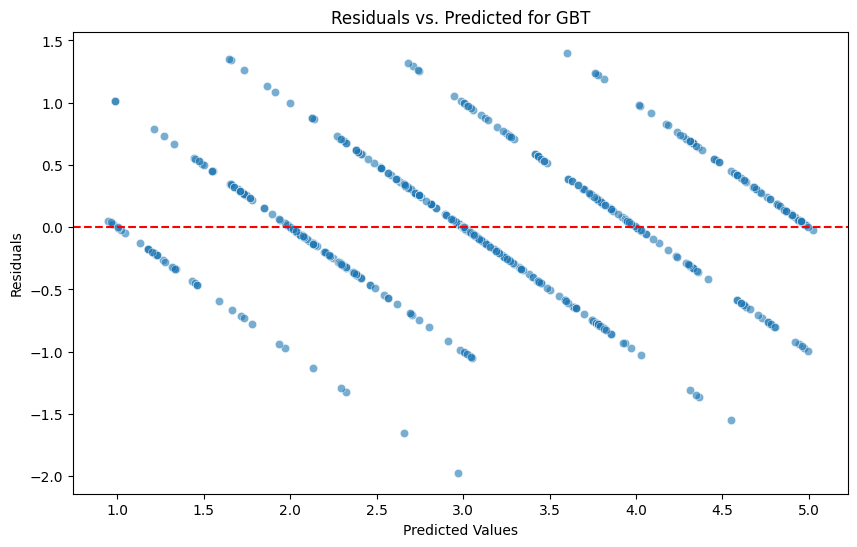

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_residuals(predictions_pd, model_name):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='prediction', y='Residuals', data=predictions_pd, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'Residuals vs. Predicted for {model_name}')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.show()

plot_residuals(lr_predictions_pd, 'Linear Regression')
plot_residuals(dt_predictions_pd, 'Decision Tree')
plot_residuals(rf_predictions_pd, 'Random Forest')
plot_residuals(gbt_predictions_pd, 'GBT')

**Visualize Cross-Validation Results**
Create visualizations to display how the RMSE changes with different hyperparameters.

To visualize the results of your cross-validation process effectively, you can create plots that show how each combination of hyperparameters performed across different folds. This helps in understanding the stability and effectiveness of the parameter settings.

Collect Cross-Validation Metrics: First, extract the cross-validation metrics for each parameter combination. The CrossValidatorModel stores the metrics for each parameter grid point across all folds, which we can access using the avgMetrics attribute.

In [ ]:
# Retrieve RMSE for each parameter set across all folds
avg_rmse_scores = cv_model.avgMetrics

# Extract the parameter grid combinations used during cross-validation
params = [{p.name: v for p, v in m.items()} for m in cv_model.getEstimatorParamMaps()]

# Combine scores with parameter settings
params_with_scores = [(x, y) for x, y in zip(params, avg_rmse_scores)]

Convert to DataFrame for Easier Handling: Convert this data into a Pandas DataFrame for easier manipulation and visualization.

In [ ]:
import pandas as pd

# Create DataFrame
results_df = pd.DataFrame(params_with_scores, columns=['Parameters', 'RMSE'])

# Explode the parameters column into separate columns
results_df = pd.concat([results_df.drop(['Parameters'], axis=1), results_df['Parameters'].apply(pd.Series)], axis=1)

**RMSE vs. Number of Trees (for Random Forest)**

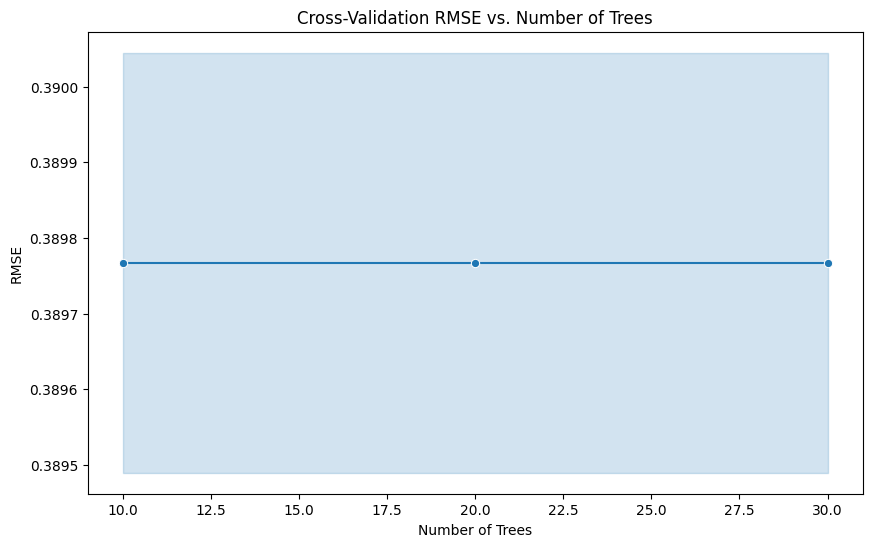

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter DataFrame for Random Forest results (if mixed models in grid)
rf_results = results_df[results_df['numTrees'].notnull()]

plt.figure(figsize=(10, 6))
sns.lineplot(x='numTrees', y='RMSE', data=rf_results, marker='o')
plt.title('Cross-Validation RMSE vs. Number of Trees')
plt.xlabel('Number of Trees')
plt.ylabel('RMSE')
plt.show()

**RMSE vs. Max Iterations (for GBT)**

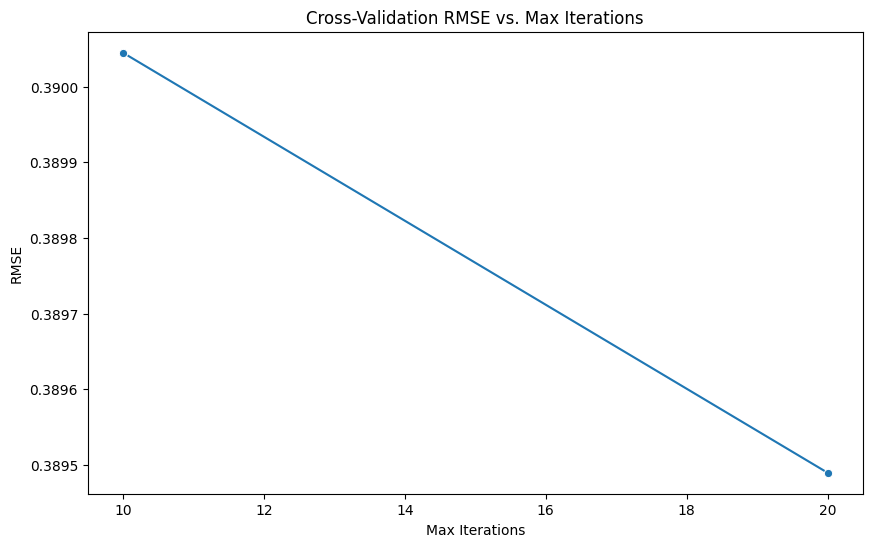

In [ ]:
# Filter DataFrame for GBT results (if mixed models in grid)
gbt_results = results_df[results_df['maxIter'].notnull()]

plt.figure(figsize=(10, 6))
sns.lineplot(x='maxIter', y='RMSE', data=gbt_results, marker='o')
plt.title('Cross-Validation RMSE vs. Max Iterations')
plt.xlabel('Max Iterations')
plt.ylabel('RMSE')
plt.show()

**I provide the comprehensive explanation about the visualization part in the result section of the paper.**